# Deep Learning

## Assignment 3

### Question 2
### Denoising Autoencoders

In this question of the assignment, we will design an autoencoder which will be used to denoise images from the MNIST dataset. Let us start by loading the MNIST dataset and adding noise to the images.

In [58]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random

In [88]:
batch_size = 100
std_dev = 0.3

train_dataset_noisy = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x + std_dev*torch.randn_like(x))]))
train_dataset_denoised = torchvision.datasets.MNIST(root='./data', train = True, transform = transforms.ToTensor(), download = True)

dataset_noise = torch.zeros(60000, 1, 28, 28)
dataset_denoise = torch.zeros(60000, 1, 28, 28)

for i in range(len(train_dataset_noisy)):
    dataset_noise[i] = torch.clamp(train_dataset_noisy[i][0], 0, 1)
    dataset_denoise[i] = train_dataset_denoised[i][0]

train_dataset = TensorDataset(dataset_noise, dataset_denoise)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset_noisy = torchvision.datasets.MNIST(root='./data', train=False, transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x + std_dev*torch.randn_like(x))]))
test_dataset_denoised = torchvision.datasets.MNIST(root='./data', train=False, transform = transforms.ToTensor(), download = True)

dataset_noise = torch.zeros(len(test_dataset_denoised), 1, 28, 28)
dataset_denoise = torch.zeros(len(test_dataset_denoised), 1, 28, 28)

for i in range(len(test_dataset_noisy)):
    dataset_noise[i] = torch.clamp(test_dataset_noisy[i][0], 0, 1)
    dataset_denoise[i] = test_dataset_denoised[i][0]

test_dataset = TensorDataset(dataset_noise, dataset_denoise)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

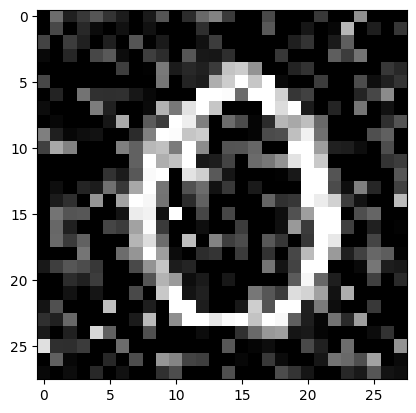

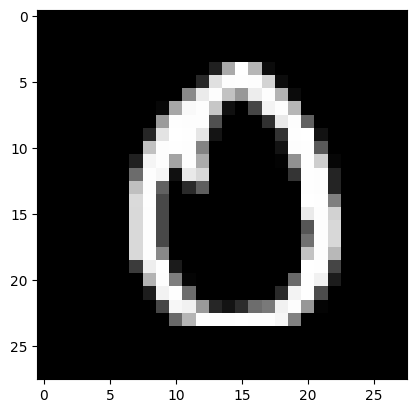

In [89]:
noise, denoise = next(iter(train_loader))
plt.imshow(noise[0][0], cmap='gray')
plt.figure()
plt.imshow(denoise[0][0], cmap='gray')

Now let us make the model for the autoencoder.

In [90]:
class Encoder(nn.Module):
    
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        return x

class Decoder(nn.Module):

    def __init__(self):
        super(Decoder, self).__init__()
        self.conv1 = nn.Conv2d(64, 32, 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 1, 3, padding = 1)
        self.upsample = nn.Upsample(scale_factor=2, mode = 'bilinear', align_corners=False)

    def forward(self, x):
        x = self.upsample(F.relu(self.conv1(x)))
        x = self.upsample(F.relu(self.conv2(x)))
        return x

class CNNAutoencoder(nn.Module):
    
    def __init__(self):
        super(CNNAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


Now we will start the training process for the above model

In [91]:
learning_rate = 0.001
num_epochs = 10

model = CNNAutoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

n_total_steps = len(train_loader)
losses = []
train_loss = 0.0

for epoch in range(num_epochs):
    for i ,(noisy_image, denoisy_image) in enumerate(train_loader):

        output = model(noisy_image)
        loss = criterion(output, denoisy_image)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if (i + 1) % 100 == 0:
            print(f'Epoch[{epoch+1}/{num_epochs}], step [{i+1}/{n_total_steps}], Loss : [{loss.item():.4f}]')

    losses.append(train_loss/n_total_steps)
    train_loss = 0.0

Epoch[1/10], step [100/600], Loss : [0.0257]
Epoch[1/10], step [200/600], Loss : [0.0210]
Epoch[1/10], step [300/600], Loss : [0.0200]
Epoch[1/10], step [400/600], Loss : [0.0181]
Epoch[1/10], step [500/600], Loss : [0.0173]
Epoch[1/10], step [600/600], Loss : [0.0176]
Epoch[2/10], step [100/600], Loss : [0.0176]
Epoch[2/10], step [200/600], Loss : [0.0182]
Epoch[2/10], step [300/600], Loss : [0.0171]
Epoch[2/10], step [400/600], Loss : [0.0161]
Epoch[2/10], step [500/600], Loss : [0.0162]
Epoch[2/10], step [600/600], Loss : [0.0169]
Epoch[3/10], step [100/600], Loss : [0.0156]
Epoch[3/10], step [200/600], Loss : [0.0156]
Epoch[3/10], step [300/600], Loss : [0.0158]
Epoch[3/10], step [400/600], Loss : [0.0154]
Epoch[3/10], step [500/600], Loss : [0.0160]
Epoch[3/10], step [600/600], Loss : [0.0158]
Epoch[4/10], step [100/600], Loss : [0.0156]
Epoch[4/10], step [200/600], Loss : [0.0148]
Epoch[4/10], step [300/600], Loss : [0.0156]
Epoch[4/10], step [400/600], Loss : [0.0155]
Epoch[4/10

Now let us visualise the MSE plots for the above

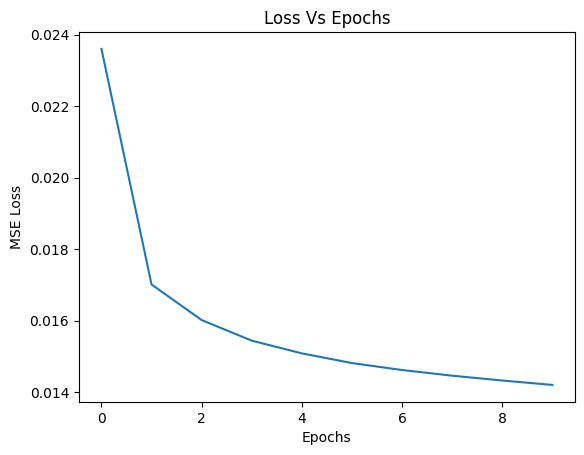

In [92]:
plt.plot(range(num_epochs), losses)
plt.title('Loss Vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.show()

Now let us run our model on the test dataset

In [93]:
with torch.no_grad():
    output = model(dataset_noise)
    loss = criterion(output, dataset_denoise)

    print(f'Loss on the test dataset is: {loss}')

Loss on the test dataset is: 0.013982073403894901


Now let us print the images of 10 random inputs to visualise the results.

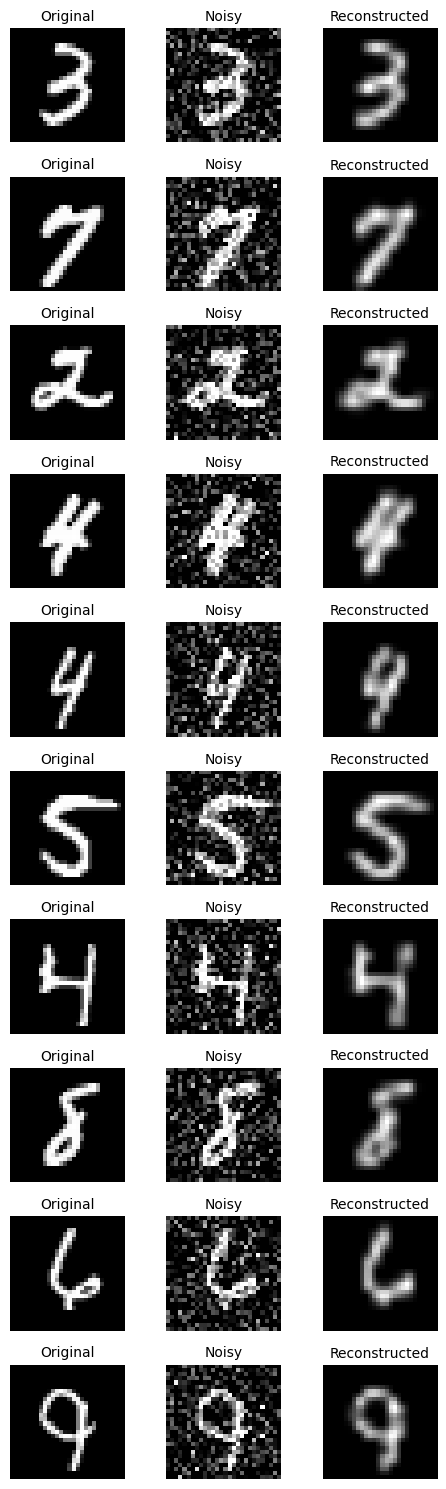

In [94]:
random_int = [random.randint(0, 10000) for _ in range(10)]

fig, axes = plt.subplots(10, 3, figsize = (5, 15))
for i, int in enumerate(random_int):
    axes[i, 0].imshow(dataset_denoise[int].squeeze(), cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Original', fontsize = 10)

    axes[i, 1].imshow(dataset_noise[int].squeeze(), cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Noisy', fontsize = 10)

    axes[i, 2].imshow(output[int].squeeze(), cmap='gray')
    axes[i, 2].axis('off')
    axes[i, 2].set_title('Reconstructed', fontsize = 10)

plt.tight_layout()
plt.show()